# Single qubit GST on the 5 qubit chip (Data from 3.5.2023)

In [1]:
# Note: I removed the mGST folders from within the qibocal fork, such that it is installed and updated seperately
from mGST import compatibility,algorithm, optimization, low_level_jit, additional_fns

In [2]:
import pickle as pickle
from pygsti.report import reportables as rptbl #Needs cvxpy!
from pygsti.modelpacks import smq1Q_XYI as std
import pygsti
from argparse import Namespace
import numpy as np
import pandas as pd
import numpy.linalg as la
import json
import matplotlib.pyplot as plt

%run ../src/mGST/reporting.py

In [ ]:
np.show_config()

blas_mkl_info:
  NOT AVAILABLE
blis_info:
  NOT AVAILABLE
openblas_info:
    libraries = ['openblas', 'openblas']
    library_dirs = ['/usr/local/lib']
    language = c
    define_macros = [('HAVE_CBLAS', None)]
    runtime_library_dirs = ['/usr/local/lib']
blas_opt_info:
    libraries = ['openblas', 'openblas']
    library_dirs = ['/usr/local/lib']
    language = c
    define_macros = [('HAVE_CBLAS', None)]
    runtime_library_dirs = ['/usr/local/lib']
lapack_mkl_info:
  NOT AVAILABLE
openblas_lapack_info:
    libraries = ['openblas', 'openblas']
    library_dirs = ['/usr/local/lib']
    language = c
    define_macros = [('HAVE_CBLAS', None)]
    runtime_library_dirs = ['/usr/local/lib']
lapack_opt_info:
    libraries = ['openblas', 'openblas']
    library_dirs = ['/usr/local/lib']
    language = c
    define_macros = [('HAVE_CBLAS', None)]
    runtime_library_dirs = ['/usr/local/lib']
Supported SIMD extensions in this NumPy install:
    baseline = SSE,SSE2,SSE3
    found = SSSE3,SSE4

### Setting the parameters

In [5]:
pdim = 2   # physical dimension
r = pdim**2   # rank of the gate superoperators 

l = 7  # maximum number of gates in each measurement sequence
d = 3  # number of gates
rK = 1   # rank of the model estimate
n_povm = 2   # number of POVM-elements

meas_samples = 1e4

### Loading data

In [6]:
with open('data/qw5q-qubit1-slow.json') as f:
    data = json.load(f)
print(data.keys())
J = np.array(data['sequences'])
y = np.array(data['hardware_probabilities']).T

dict_keys(['platform', 'qubit', 'depth', 'nsequences', 'nshots', 'execution_times', 'sequences', 'hardware_probabilities'])


### GST

In [ ]:
bsize = 50   # The batch size on which the optimization is started

results = []
for rK in [1,4]: 
    X_t,E_t,rho_t = compatibility.pygsti_model_to_arrays(std.target_model(),basis = 'std') #The idle-X(pi/w)-Y(pi/2) model 
    K_t = additional_fns.Kraus_rep(X_t,d,pdim,rK)
    X_t = np.einsum('ijkl,ijnm -> iknlm', K_t, K_t.conj()).reshape(d,r,r)  
    K,X,E,rho,res_list = algorithm.run_mGST(y,J,l,d,r,rK, n_povm, bsize, meas_samples, method = 'SFN',
                         max_inits = 20, max_iter = 50, final_iter = 80, threshold_multiplier = 100, 
                         target_rel_prec = 1e-4, testing = True)   
    results.append([K,X,E,rho])

### Save data

In [34]:
# ###################################### 
# filename = 'results-qubit1-slow'
# parameters = {'sequence length':l,'gate count':d,'Kraus ranks':[1,4],'phys. dimension':int(np.sqrt(r)), 'Sequence count': len(J), 
#               'J':J,'y':y,'threshold_multiplier': 30, 
#                      'target_rel_prec':1e-4}
# data_to_safe = {'parameters':parameters, 'results':results}

# with open(filename, 'wb') as handle:
#     pickle.dump(data_to_safe, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Analysis

### Rank 1

In [20]:
for i in range(1,4):
    filename = "results-qubit%i-slow"%i
    with open(filename, 'rb') as handle:
        b = pickle.load(handle)
    results = b['results']

    # Performance metrics rank 1
    print("\n", filename)
    K,X,E,rho = results[0][:]
    weights = {'G0': 1,'G1': 1, 'G2': 1, 'spam': 1}
    gate_labels = {0: "Id", 1: "Rx(pi/2)", 2: "Ry(pi/2)"}
    df_g, df_o, s_g, s_o, gauge_optimized_mdl = gauge_opt_report(
        X, E, rho, J, y, std.target_model(), weights, gate_labels)
    display(s_g), display(s_o)
    
    pdim = int(np.sqrt(rho.shape[0]))
    mdl = compatibility.arrays_to_pygsti_model(X,E,rho, basis = 'std')
    X_t,E_t,rho_t = compatibility.pygsti_model_to_arrays(std.target_model(),basis = 'std')
    target_mdl = compatibility.arrays_to_pygsti_model(X_t,E_t,rho_t, basis = 'std') #For consistent gate labels

    gauge_optimized_mdl = gaugeopt_to_target(mdl, 
                target_mdl,gauge_group = gaugegroup.UnitaryGaugeGroup(std.target_model().state_space, basis = 'pp'),
                item_weights=weights)
    X_opt,E_opt,rho_opt = compatibility.pygsti_model_to_arrays(gauge_optimized_mdl,basis = 'std')      
    


 results-qubit1-slow


,F_avg,Diamond distances
Id,"0,99676","0,06976"
Rx(pi/2),"0,99986","0,01443"
Ry(pi/2),"0,99991","0,01184"


,Final cost function value,Mean total variation dist. to data,Mean total variation dist. target to data,POVM - Choi map trace distance,State - Trace distance
,0.000116,0.008653,0.127257,0.180404,0.041337



 results-qubit2-slow


,F_avg,Diamond distances
Id,"0,99264","0,10506"
Rx(pi/2),"0,99946","0,02851"
Ry(pi/2),"0,99951","0,02713"


,Final cost function value,Mean total variation dist. to data,Mean total variation dist. target to data,POVM - Choi map trace distance,State - Trace distance
,0.004442,0.055895,0.127257,0.117284,0.063415



 results-qubit3-slow


,F_avg,Diamond distances
Id,"0,99937","0,03069"
Rx(pi/2),"0,99990","0,01252"
Ry(pi/2),"0,99979","0,01785"


,Final cost function value,Mean total variation dist. to data,Mean total variation dist. target to data,POVM - Choi map trace distance,State - Trace distance
,0.016072,0.103690,0.127257,0.909522,0.999040


In [14]:
help(la.norm)

Help on function norm in module numpy.linalg:

norm(x, ord=None, axis=None, keepdims=False)
    Matrix or vector norm.
    
    This function is able to return one of eight different matrix norms,
    or one of an infinite number of vector norms (described below), depending
    on the value of the ``ord`` parameter.
    
    Parameters
    ----------
    x : array_like
        Input array.  If `axis` is None, `x` must be 1-D or 2-D, unless `ord`
        is None. If both `axis` and `ord` are None, the 2-norm of
        ``x.ravel`` will be returned.
    ord : {non-zero int, inf, -inf, 'fro', 'nuc'}, optional
        Order of the norm (see table under ``Notes``). inf means numpy's
        `inf` object. The default is None.
    axis : {None, int, 2-tuple of ints}, optional.
        If `axis` is an integer, it specifies the axis of `x` along which to
        compute the vector norms.  If `axis` is a 2-tuple, it specifies the
        axes that hold 2-D matrices, and the matrix norms of these

### Rank 4

In [63]:
for i in range(1,4):
    filename = "results-qubit%i-slow"%i
    with open(filename, 'rb') as handle:
        b = pickle.load(handle)
    results = b['results']

    # Performance metrics rank 1
    print("\n", filename)
    K,X,E,rho = results[1][:]
    weights = {'G0': 1,'G1': 1, 'G2': 1, 'spam': 1}
    gate_labels = {0: "Id", 1: "Rx(pi/2)", 2: "Ry(pi/2)"}
    df_g, df_o, s_g, s_o, gauge_optimized_mdl = gauge_opt_report(
        X, E, rho, J, y, std.target_model(), weights, gate_labels)
    display(s_g), display(s_o)


 results-qubit1-slow


,F_avg,Diamond distances
Id,"0,98244","0,08036"
Rx(pi/2),"0,33955","0,99997"
Ry(pi/2),"0,98050","0,04737"


,Final cost function value,Mean total variation dist. to data,Mean total variation dist. target to data,POVM - Choi map trace distance,State - Trace distance
,0.000083,0.006859,0.127257,0.084479,0.020444



 results-qubit2-slow


,F_avg,Diamond distances
Id,"0,98582","0,11144"
Rx(pi/2),"0,99145","0,03503"
Ry(pi/2),"0,99448","0,03315"


,Final cost function value,Mean total variation dist. to data,Mean total variation dist. target to data,POVM - Choi map trace distance,State - Trace distance
,0.004420,0.055039,0.127257,0.091575,0.061787



 results-qubit3-slow


,F_avg,Diamond distances
Id,"0,98963","0,03500"
Rx(pi/2),"0,98997","0,02958"
Ry(pi/2),"0,98755","0,03066"


,Final cost function value,Mean total variation dist. to data,Mean total variation dist. target to data,POVM - Choi map trace distance,State - Trace distance
,0.016026,0.103222,0.127257,0.027122,0.024267


### Gate plots

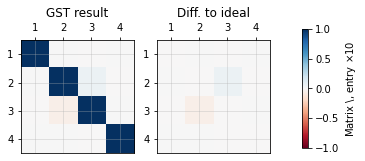

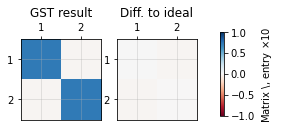

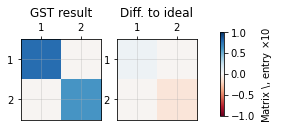

In [15]:
X_pp, E_pp, rho_pp = compatibility.pygsti_model_to_arrays(gauge_optimized_mdl,basis = 'pp')
X_t_pp, E_t_pp, rho_t_pp = compatibility.pygsti_model_to_arrays(std.target_model(),basis = 'pp')

gate_index = 0
plot_diff(X_pp[gate_index], X_t_pp[gate_index])

plot_diff(rho_pp.reshape(pdim,pdim), rho_t_pp.reshape(pdim,pdim))
plot_diff(E_pp[0].reshape(pdim,pdim), E_t_pp[0].reshape(pdim,pdim))